# Complex I model
Comparing Gauthier, Markevich, and simplified complex I models

In [1]:
using ModelingToolkit
using ModelingToolkit: t_nounits as t, D_nounits as D
using SteadyStateDiffEq
using OrdinaryDiffEq
using NaNMath
using Plots
using ECMEDox
using ECMEDox: mM, μM, nM, iVT, mV, Molar, Hz, ms

Gauthier 2012 7-state QSSA model

In [2]:
function c1_gauthier(; name=:c1gauthier,
    Q_n=1800μM, QH2_n=200μM, nad=500μM, nadh=500μM,
    dpsi=150mV, O2=6μM, sox_m=0.1μM,
    h_i=exp10(-7) * Molar, h_m=exp10(-7.6) * Molar,
    C1_INHIB=1)
    @parameters begin
        ET_C1 = 8.85mM      ## Activity of complex I
        dpsi_B_C1 = 50mV    ## Phase boundary potential
        # Transition rates
        K12_C1 = 6.3396E11Hz/mM^2
        K21_C1 = 5Hz
        K56_C1 = 100Hz
        K65_C1 = 2.5119E13Hz/mM^2
        K61_C1 = 1e7Hz
        K16_C1 = 130Hz
        K23_C1 = 3886.7Hz / sqrt(mM)
        K32_C1 = 9.1295e6Hz
        K34_C1 = 639.1364Hz
        K43_C1 = 3.2882Hz / sqrt(mM)
        K47_C1 = 1.5962E7Hz / mM
        K74_C1 = 65.2227Hz
        K75_C1 = 24615Hz
        K57_C1 = 1166.7Hz / sqrt(mM)
        K42_C1 = 6.0318Hz / mM
        Em_O2_SOX = -160mV         ## O2/Superoxide redox potential
        Em_FMNH2_FMNH = -375mV     ## FMNH/FMNH2 redox potential
        rKEQ_ROS_C1 = exp(iVT * (Em_FMNH2_FMNH - Em_O2_SOX))
    end

    @variables begin
        C1_1(t)
        C1_2(t)
        C1_3(t)
        C1_4(t)
        C1_5(t)
        C1_6(t)
        C1_7(t)
        wC1_1(t)
        wC1_2(t)
        wC1_3(t)
        wC1_4(t)
        wC1_5(t)
        wC1_6(t)
        wC1_7(t)
        vQC1(t)
        vNADHC1(t)
        vROSC1(t)
        vHresC1(t)
        TNC1(t) ## Turnover number
    end

    fv = exp(iVT * (dpsi - dpsi_B_C1))
    # State transition rates
    a12 = K12_C1 * h_m^2
    a21 = K21_C1
    a65 = K65_C1 * h_i^2
    a56 = K56_C1
    a61 = K61_C1 / fv
    a16 = K16_C1 * fv
    a23 = K23_C1 * NaNMath.sqrt(nadh)
    a32 = K32_C1
    a34 = K34_C1
    a43 = K43_C1 * NaNMath.sqrt(nad)
    a47 = C1_INHIB * K47_C1 * NaNMath.sqrt(Q_n * h_m)
    a74 = K74_C1
    a57 = C1_INHIB * K57_C1 * NaNMath.sqrt(QH2_n)
    a75 = K75_C1
    a42 = K42_C1 * O2
    a24 = K42_C1 * rKEQ_ROS_C1 * sox_m

    # KA pattern
    w1 = a21 * a32 * a42 * a56 * a61 * a74 + a21 * a32 * a42 * a56 * a61 * a75 + a21 * a32 * a42 * a57 * a61 * a74 + a21 * a32 * a42 * a57 * a65 * a74 + a21 * a32 * a43 * a56 * a61 * a74 + a21 * a32 * a43 * a56 * a61 * a75 + a21 * a32 * a43 * a57 * a61 * a74 + a21 * a32 * a43 * a57 * a65 * a74 + a21 * a32 * a47 * a56 * a61 * a75 + a21 * a34 * a42 * a56 * a61 * a74 + a21 * a34 * a42 * a56 * a61 * a75 + a21 * a34 * a42 * a57 * a61 * a74 + a21 * a34 * a42 * a57 * a65 * a74 + a21 * a34 * a47 * a56 * a61 * a75 + a23 * a34 * a47 * a56 * a61 * a75 + a24 * a32 * a47 * a56 * a61 * a75 + a24 * a34 * a47 * a56 * a61 * a75
    w2 = a12 * a32 * a42 * a56 * a61 * a74 + a12 * a32 * a42 * a56 * a61 * a75 + a12 * a32 * a42 * a57 * a61 * a74 + a12 * a32 * a42 * a57 * a65 * a74 + a12 * a32 * a43 * a56 * a61 * a74 + a12 * a32 * a43 * a56 * a61 * a75 + a12 * a32 * a43 * a57 * a61 * a74 + a12 * a32 * a43 * a57 * a65 * a74 + a12 * a32 * a47 * a56 * a61 * a75 + a12 * a34 * a42 * a56 * a61 * a74 + a12 * a34 * a42 * a56 * a61 * a75 + a12 * a34 * a42 * a57 * a61 * a74 + a12 * a34 * a42 * a57 * a65 * a74 + a12 * a34 * a47 * a56 * a61 * a75 + a16 * a32 * a42 * a57 * a65 * a74 + a16 * a32 * a43 * a57 * a65 * a74 + a16 * a34 * a42 * a57 * a65 * a74
    w3 = a12 * a23 * a42 * a56 * a61 * a74 + a12 * a23 * a42 * a56 * a61 * a75 + a12 * a23 * a42 * a57 * a61 * a74 + a12 * a23 * a42 * a57 * a65 * a74 + a12 * a23 * a43 * a56 * a61 * a74 + a12 * a23 * a43 * a56 * a61 * a75 + a12 * a23 * a43 * a57 * a61 * a74 + a12 * a23 * a43 * a57 * a65 * a74 + a12 * a23 * a47 * a56 * a61 * a75 + a12 * a24 * a43 * a56 * a61 * a74 + a12 * a24 * a43 * a56 * a61 * a75 + a12 * a24 * a43 * a57 * a61 * a74 + a12 * a24 * a43 * a57 * a65 * a74 + a16 * a21 * a43 * a57 * a65 * a74 + a16 * a23 * a42 * a57 * a65 * a74 + a16 * a23 * a43 * a57 * a65 * a74 + a16 * a24 * a43 * a57 * a65 * a74
    w4 = a12 * a23 * a34 * a56 * a61 * a74 + a12 * a23 * a34 * a56 * a61 * a75 + a12 * a23 * a34 * a57 * a61 * a74 + a12 * a23 * a34 * a57 * a65 * a74 + a12 * a24 * a32 * a56 * a61 * a74 + a12 * a24 * a32 * a56 * a61 * a75 + a12 * a24 * a32 * a57 * a61 * a74 + a12 * a24 * a32 * a57 * a65 * a74 + a12 * a24 * a34 * a56 * a61 * a74 + a12 * a24 * a34 * a56 * a61 * a75 + a12 * a24 * a34 * a57 * a61 * a74 + a12 * a24 * a34 * a57 * a65 * a74 + a16 * a21 * a32 * a57 * a65 * a74 + a16 * a21 * a34 * a57 * a65 * a74 + a16 * a23 * a34 * a57 * a65 * a74 + a16 * a24 * a32 * a57 * a65 * a74 + a16 * a24 * a34 * a57 * a65 * a74
    w5 = a12 * a23 * a34 * a47 * a61 * a75 + a12 * a23 * a34 * a47 * a65 * a75 + a12 * a24 * a32 * a47 * a61 * a75 + a12 * a24 * a32 * a47 * a65 * a75 + a12 * a24 * a34 * a47 * a61 * a75 + a12 * a24 * a34 * a47 * a65 * a75 + a16 * a21 * a32 * a42 * a65 * a74 + a16 * a21 * a32 * a42 * a65 * a75 + a16 * a21 * a32 * a43 * a65 * a74 + a16 * a21 * a32 * a43 * a65 * a75 + a16 * a21 * a32 * a47 * a65 * a75 + a16 * a21 * a34 * a42 * a65 * a74 + a16 * a21 * a34 * a42 * a65 * a75 + a16 * a21 * a34 * a47 * a65 * a75 + a16 * a23 * a34 * a47 * a65 * a75 + a16 * a24 * a32 * a47 * a65 * a75 + a16 * a24 * a34 * a47 * a65 * a75
    w6 = a12 * a23 * a34 * a47 * a56 * a75 + a12 * a24 * a32 * a47 * a56 * a75 + a12 * a24 * a34 * a47 * a56 * a75 + a16 * a21 * a32 * a42 * a56 * a74 + a16 * a21 * a32 * a42 * a56 * a75 + a16 * a21 * a32 * a42 * a57 * a74 + a16 * a21 * a32 * a43 * a56 * a74 + a16 * a21 * a32 * a43 * a56 * a75 + a16 * a21 * a32 * a43 * a57 * a74 + a16 * a21 * a32 * a47 * a56 * a75 + a16 * a21 * a34 * a42 * a56 * a74 + a16 * a21 * a34 * a42 * a56 * a75 + a16 * a21 * a34 * a42 * a57 * a74 + a16 * a21 * a34 * a47 * a56 * a75 + a16 * a23 * a34 * a47 * a56 * a75 + a16 * a24 * a32 * a47 * a56 * a75 + a16 * a24 * a34 * a47 * a56 * a75
    w7 = a12 * a23 * a34 * a47 * a56 * a61 + a12 * a23 * a34 * a47 * a57 * a61 + a12 * a23 * a34 * a47 * a57 * a65 + a12 * a24 * a32 * a47 * a56 * a61 + a12 * a24 * a32 * a47 * a57 * a61 + a12 * a24 * a32 * a47 * a57 * a65 + a12 * a24 * a34 * a47 * a56 * a61 + a12 * a24 * a34 * a47 * a57 * a61 + a12 * a24 * a34 * a47 * a57 * a65 + a16 * a21 * a32 * a42 * a57 * a65 + a16 * a21 * a32 * a43 * a57 * a65 + a16 * a21 * a32 * a47 * a57 * a65 + a16 * a21 * a34 * a42 * a57 * a65 + a16 * a21 * a34 * a47 * a57 * a65 + a16 * a23 * a34 * a47 * a57 * a65 + a16 * a24 * a32 * a47 * a57 * a65 + a16 * a24 * a34 * a47 * a57 * a65

    den = wC1_1 + wC1_2 + wC1_3 + wC1_4 + wC1_5 + wC1_6 + wC1_7

    v47 = a47 * C1_4 - a74 * C1_7
    v42 = a42 * C1_4 - a24 * C1_2
    v23 = a23 * C1_2 - a32 * C1_3
    v61 = a61 * C1_1 - a16 * C1_6
    eqs = [
        wC1_1 ~ w1,
        wC1_2 ~ w2,
        wC1_3 ~ w3,
        wC1_4 ~ w4,
        wC1_5 ~ w5,
        wC1_6 ~ w6,
        wC1_7 ~ w7,
        C1_1 ~ wC1_1 / den * ET_C1,
        C1_2 ~ wC1_2 / den * ET_C1,
        C1_3 ~ wC1_3 / den * ET_C1,
        C1_4 ~ wC1_4 / den * ET_C1,
        C1_7 ~ wC1_5 / den * ET_C1,
        C1_5 ~ wC1_6 / den * ET_C1,
        C1_6 ~ wC1_7 / den * ET_C1,
        vQC1 ~ -0.5 * v47,
        vROSC1 ~ v42,
        vNADHC1 ~ -0.5 * v23,
        vHresC1 ~ 2 * v61,
        TNC1 ~ -vNADHC1 / ET_C1,
    ]
    return System(eqs, t; name)
end

c1_gauthier (generic function with 1 method)

Markevich 2015 mass action law model
https://pmc.ncbi.nlm.nih.gov/articles/PMC4426091/

In [3]:
function c1_markevich_full(; name=:c1markevich_full,
    Q_n=1.8mM, QH2_n=0.2mM,
    nad=500μM, nadh=500μM,
    dpsi=150mV, O2=6μM, sox_m=0.1μM,
    h_i=exp10(-7) * Molar, h_m=exp10(-7.6) * Molar,
    DOX=0μM, ROTENONE_BLOCK=0)
    @parameters begin
        Em_O2_SOX = -160mV        ## O2/Superoxide redox potential
        Em_FMN_FMNsq = -387mV     ## FMN/FMNH- avg redox potential
        Em_FMNsq_FMNH = -293mV    ## FMN semiquinone/FMNH- redox potential
        Em_FMN_FMNH = -340mV      ## FMN/FMNH- avg redox potential
        Em_NAD = -320mV           ## NAD/NADH avg redox potential
        Em_N3 = -250mV
        Em_N2 = -80mV
        Em_N1a = -370mV
        Em_Q_SQ_C1 = -300mV       ## -213mV in Markevich, 2015
        Em_SQ_QH2_C1 = +500mV     ## ~800mV (?) in Markevich, 2015
        ET_C1 = 17μM              ## Activity of complex I
        # DOX IC50 on complex I
        KI_DOX_C1 = 400μM
        kf1_C1 = 83Hz / μM
        KEQ1_C1 = 0.01 / μM
        kf2_C1 = 1.44e12Hz
        kf3_C1 = 1e6Hz
        KEQ3_C1 = 25μM
        KEQ2_C1 = exp(2iVT * (Em_FMN_FMNH - Em_NAD)) / KEQ1_C1 / KEQ3_C1
        kf4_C1 = 1Hz / μM
        KEQ4_C1 = 0.001 / μM
        kf5_C1 = 2Hz / μM
        KEQ5_C1 = 0.02 / μM
        kf6_C1 = 5e8Hz / μM
        KEQ6_C1 = exp(iVT * (Em_N3 - Em_FMNsq_FMNH))
        kf7_C1 = 10000Hz / μM
        KEQ7_C1 = exp(iVT * (Em_N2 - Em_N3))
        kf8_C1 = 10Hz / μM
        KEQ8_C1 = 0.1 / μM         ## Association constant for Q
        kf9_C1 = 4E5Hz / μM
        KEQ9_C1 = exp(iVT * (Em_Q_SQ_C1 - Em_N2))
        kf10_C1 = 2e6Hz / μM
        KEQ10_C1 = exp(iVT * (Em_N1a - Em_FMN_FMNsq))
        KEQ10B_C1 = exp(iVT * (Em_FMNsq_FMNH - Em_N1a))
        kf11_C1 = 1e9Hz / μM
        KEQ11_C1 = exp(iVT * (Em_N3 - Em_FMN_FMNsq))
        kf13_C1 = 2.7e6Hz / μM
        kf14_C1 = 1000Hz
        KEQ14_C1 = 20μM             ## Dissociation constant for QH2
        kf16_C1 = 2Hz / μM          ## SOX production rate from If site
        KEQ16_C1 = exp(iVT * (Em_O2_SOX - Em_FMNsq_FMNH))
        kf17_C1 = 0.04Hz / μM       ## SOX production rate from Iq site
        KEQ17_C1 = exp(iVT * (Em_O2_SOX - Em_Q_SQ_C1))
    end

    @variables begin
        Iq_C1(t) ## Conserved
        Q_C1(t) = 0
        SQ_C1(t) = 0
        QH2_C1(t) = 0
        FMN(t) ## Conserved
        FMN_NADH(t) = 0
        FMNH_NAD(t) = 0
        FMN_NAD(t) = 0
        FMNH_NADH(t) = 0
        FMNH(t) = 0
        FMNsq(t) = 0
        N2_C1(t)
        N2r_C1(t) = 0
        N3_C1(t)
        N3r_C1(t) = 0
        N1a_C1(t)
        N1ar_C1(t) = 0
        KEQ13_C1(t)
        vQC1(t)
        vQH2C1(t)
        vNADHC1(t)
        vNADC1(t)
        vROSIf(t)
        vROSIq(t)
        vROSC1(t)
        TNC1(t) ## NADH turnover number
        vHresC1(t)
    end

    fhm = h_m / 1E-7Molar
    C1_INHIB = (1 - ROTENONE_BLOCK)
    # NADH + FMN = FMN.NADH
    v1 = kf1_C1 * (nadh * FMN - FMN_NADH / KEQ1_C1)
    # FMN.NADH = FMNH−.NAD+
    v2 = kf2_C1 * (FMN_NADH - FMNH_NAD / KEQ2_C1)
    # FMNH−.NAD+ = FMNH− + NAD+
    v3 = kf3_C1 * (FMNH_NAD - FMNH * nad / KEQ3_C1)
    # FMN + NAD+ = FMN.NAD+
    v4 = kf4_C1 * (nad * FMN - FMN_NAD / KEQ4_C1)
    # FMNH− + NADH = FMNH−.NADH
    v5 = kf5_C1 * (FMNH * nadh - FMNH_NADH / KEQ5_C1)
    # FMNH− + N3 = FMNHsq + N3−
    v6 = kf6_C1 * (FMNH * N3_C1 - FMNsq * N3r_C1 / KEQ6_C1)
    # N3− + N2 = N3 + N2−
    v7 = kf7_C1 * (N3r_C1 * N2_C1 - N3_C1 * N2r_C1 / KEQ7_C1)
    # Q association
    q = Q_n * C1_INHIB
    v8 = kf8_C1 * (Iq_C1 * q - Q_C1 / KEQ8_C1)
    # CI.Q + N2− = CIQsq + N2
    v9 = kf9_C1 * (Q_C1 * N2r_C1 - SQ_C1 * N2_C1 / KEQ9_C1)
    # FMNHsq + N1a = FMN + N1a− + Hi+
    v10 = kf10_C1 * (FMNsq * N1a_C1 - FMN * N1ar_C1 * fhm / KEQ10_C1)
    # FMNsq + N1a− = FMNH- + N1a
    v10b = kf10_C1 * (FMNsq * N1ar_C1 - FMNH * N1a_C1 / KEQ10B_C1)
    # FMNHsq + N3 = FMN + N3− + Hi+
    v11 = kf11_C1 * (FMNsq * N3_C1 - FMN * N3r_C1 * fhm / KEQ11_C1)
    # N2 + N3− = N2− + N3
    v12 = v7
    # Second electron transfer
    v13 = kf13_C1 * (SQ_C1 * N2r_C1 * fhm^2 - QH2_C1 * N2_C1 / KEQ13_C1)
    # QH2 dissociation
    qh2 = QH2_n * C1_INHIB
    v14 = kf14_C1 * (QH2_C1 - Iq_C1 * qh2 / KEQ14_C1)
    # Flavin site ROS generation
    v16 = kf16_C1 * (FMNH * O2 - FMNsq * sox_m / KEQ16_C1)
    # Quinone site ROS generation
    v17 = kf17_C1 * (SQ_C1 * O2 - Q_C1 * sox_m / KEQ17_C1)

    eqs = [
        ET_C1 ~ N2r_C1 + N2_C1,
        ET_C1 ~ N3r_C1 + N3_C1,
        ET_C1 ~ N1ar_C1 + N1a_C1,
        ET_C1 ~ Iq_C1 + Q_C1 + SQ_C1 + QH2_C1,
        ET_C1 ~ FMN + FMN_NADH + FMNH_NAD + FMN_NAD + FMNH_NADH + FMNH + FMNsq,
        KEQ13_C1 ~ exp(iVT * (Em_SQ_QH2_C1 - Em_N2 - 4dpsi)) * (h_m / h_i)^4,
        D(FMN_NADH) ~ v1 - v2,
        D(FMNH_NAD) ~ v2 - v3,
        D(FMN_NAD) ~ v4,
        D(FMNH_NADH) ~ v5,
        D(FMNH) ~ v3 - v5 - v16 - v6 + v10b,
        D(FMNsq) ~ v6 + v16 - v10 - v11 - v10b,
        D(N1ar_C1) ~ v10 - v10b,
        D(N3r_C1) ~ v6 + v11 - v7 - v12,
        D(N2r_C1) ~ v7 + v12 - v9 - v13,
        D(Q_C1) ~ v8 - v9 + v17,
        D(SQ_C1) ~ v9 - v17 - v13,
        D(QH2_C1) ~ v13 - v14,

        # Positive: production; negative: consumption
        vNADHC1 ~ -(v1 + v5),
        vNADC1 ~ v3 - v4,
        vQC1 ~ -v8,
        vQH2C1 ~ v14,
        vROSIf ~ v16,
        vROSIq ~ v17,
        vHresC1 ~ 4 * v13,
        vROSC1 ~ vROSIf + vROSIq,
        TNC1 ~ -vNADHC1 / ET_C1,
    ]
    return System(eqs, t; name)
end

c1_markevich_full (generic function with 1 method)

Simplified Markevich complex I model

In [4]:
function c1_markevich_s(; name=:c1s,
    Q_n=1800μM, QH2_n=200μM,
    nad=2500μM, nadh=500μM,
    dpsi=150mV, O2=6μM, sox_m=0.1μM,
    h_i=exp10(-7) * Molar, h_m=exp10(-7.6) * Molar,
    DOX=0μM, ROTENONE_BLOCK=0, MT_PROT=1)

    @parameters begin
        ET_C1 = 17μM                ## Activity of complex I
        KI_DOX_C1 = 400μM           ## DOX IC50 on complex I
        Em_O2_SOX = -160mV        ## O2/Superoxide redox potential
        Em_FMN_FMNsq = -387mV     ## FMN/FMNH- avg redox potential
        Em_FMNsq_FMNH = -293mV    ## FMN semiquinone/FMNH- redox potential
        Em_FMN_FMNH = -340mV      ## FMN/FMNH- avg redox potential
        Em_NAD = -320mV           ## NAD/NADH avg redox potential
        Em_N3 = -250mV
        Em_N2 = -80mV
        Em_N1a = -370mV
        Em_Q_SQ_C1 = -300mV       ## -213mV in Markevich, 2015
        Em_SQ_QH2_C1 = +500mV     ## ~800mV (?) in Markevich, 2015
        KI_NADH_C1 = 50μM
        KD_NADH_C1 = 100μM
        KI_NAD_C1 = 1000μM
        KD_NAD_C1 = 25μM
        # NADH + FMN = NAD+ + FMNH-
        KEQ_NADH_FMN = exp(2iVT * (Em_FMN_FMNH - Em_NAD))
        # 2FMNsq = (N1a) = FMN + FMNH- + H+
        rKEQ_FMNsq_Dis = exp(-iVT * (Em_FMNsq_FMNH - Em_FMN_FMNsq))
        # FMNH- + N3 = FMNsq + N3-
        KEQ_FMNH_N3 = exp(iVT * (Em_N3 - Em_FMNsq_FMNH))
        # N3- + N2 = N3 + N2-
        kf7_C1 = 10000Hz / μM
        rKEQ7_C1 = exp(-iVT * (Em_N2 - Em_N3))
        kb7_C1 = kf7_C1 * rKEQ7_C1
        kf8_C1 = 10Hz / μM
        rKEQ8_C1 = 10μM
        kb8_C1 = kf8_C1 * rKEQ8_C1
        kf9_C1 = 4E5Hz / μM
        rKEQ9_C1 = exp(-iVT * (Em_Q_SQ_C1 - Em_N2))
        kb9_C1 = kf9_C1 * rKEQ9_C1
        kf13_C1 = 2.7e6Hz / μM
        kf14_C1 = 1000Hz
        rKEQ14_C1 = inv(20μM)
        kb14_C1 = kf14_C1 * rKEQ14_C1
        kf16_C1 = 2Hz / μM          ## SOX production rate from If site
        rKEQ16_C1 = exp(-iVT * (Em_O2_SOX - Em_FMNsq_FMNH))
        kb16_C1 = kf16_C1 * rKEQ16_C1
        kf17_C1 = 0.04Hz / μM       ## SOX production rate from Iq site
        rKEQ17_C1 = exp(-iVT * (Em_O2_SOX - Em_Q_SQ_C1))
        kb17_C1 = kf17_C1 * rKEQ17_C1
    end

    @variables begin
        # Flavin site
        FMN(t)
        FMN_NAD(t)
        FMNsq(t)
        FMNH(t)
        FMNH_NADH(t)
        FMN_NADH(t)
        FMNH_NAD(t)
        # FeS cluster
        N3_C1(t)
        N3r_C1(t)
        N2_C1(t)
        N2r_C1(t) = 0
        # Quinone site
        C1(t)
        Q_C1(t)
        SQ_C1(t)
        QH2_C1(t)
        rKEQ_N2r_SQ(t)
        # Reaction rates
        vQC1(t)
        vQH2C1(t)
        vROSC1(t)
        vROSIf(t)
        vROSIq(t)
        vNADHC1(t)
        vNADC1(t)
        TNC1(t)
        vHresC1(t)
    end

    C1_CONC = ET_C1 * MT_PROT
    C1_INHIB = (1 - ROTENONE_BLOCK) / (1 + (DOX / KI_DOX_C1)^3)
    # Mitochondrial pH factor
    fhm = h_m * inv(1E-7Molar)

    # Flavin site in rapid equilibrium
    # Weights in the flavin site
    wFMN = 1
    wFMN_NAD = wFMN * nad / KI_NAD_C1
    wFMN_NADH = wFMN * nadh / KD_NADH_C1
    wFMNH = wFMN * (nadh / nad) * KEQ_NADH_FMN
    wFMNH_NAD = wFMNH * nad / KD_NAD_C1
    wFMNH_NADH = wFMNH * nadh / KI_NADH_C1
    wFMNsq = NaNMath.sqrt(wFMN * wFMNH * rKEQ_FMNsq_Dis * fhm)
    fDen = wFMN + wFMN_NAD + wFMNH + wFMNH_NADH + wFMNsq + wFMN_NADH + wFMNH_NAD
    fC1 = C1_CONC / fDen

    # Flavin site ROS generation
    v16 = kf16_C1 * FMNH * O2 - kb16_C1 * FMNsq * sox_m

    # N3− + N2 = N3 + N2−
    v7 = kf7_C1 * N3r_C1 * N2_C1 - kb7_C1 * N3_C1 * N2r_C1
    v12 = v7

    # Quinone site state transition rates
    # C1 + Q = Q_C1
    b12 = kf8_C1 * Q_n * C1_INHIB
    b21 = kb8_C1
    v8 = b12 * C1 - b21 * Q_C1
    # Q_C1 + N2r = SQ_C1 + N2
    b23a = kf9_C1 * N2r_C1
    b32a = kb9_C1 * N2_C1
    v9 = b23a * Q_C1 - b32a * SQ_C1
    # C1_SQ + N2r + 6Hm = C1_QH2 + N2 + 4Hi
    b34 = kf13_C1 * N2r_C1 * fhm^2
    b43 = kf13_C1 * rKEQ_N2r_SQ * N2_C1
    v13 = b34 * SQ_C1 - b43 * QH2_C1
    # C1_QH2 = C1 + QH2
    b41 = kf14_C1
    b14 = kb14_C1 * QH2_n * C1_INHIB
    v14 = b41 * QH2_C1 - b14 * C1
    # C1_SQ + O2 = C1_Q + sox
    b32b = kf17_C1 * O2
    b23b = kb17_C1 * sox_m
    v17 = b32b * SQ_C1 - b23b * Q_C1
    b23 = b23a + b23b
    b32 = b32a + b32b

    # KA pattern
    wC1 = b21*b32*b41 + b21*b32*b43 + b21*b34*b41 + b23*b34*b41
    wC1_Q = b12*b32*b41 + b12*b32*b43 + b12*b34*b41 + b14*b32*b43
    wC1_SQ = b12*b23*b41 + b12*b23*b43 + b14*b21*b43 + b14*b23*b43
    wC1_QH2 = b12*b23*b34 + b14*b21*b32 + b14*b21*b34 + b14*b23*b34
    qDen = wC1 + wC1_Q + wC1_SQ + wC1_QH2
    qC1 = C1_CONC / qDen

    eqs = [
        rKEQ_N2r_SQ ~ exp(-iVT * (Em_SQ_QH2_C1 - Em_N2 - 4dpsi)) * (h_i / h_m)^4,
        FMN ~ wFMN * fC1,
        FMN_NAD ~ wFMN_NAD * fC1,
        FMNH ~ wFMNH * fC1,
        FMNsq ~ wFMNsq * fC1,
        FMNH_NADH ~ wFMNH_NADH * fC1,
        FMN_NADH ~ wFMN_NADH * fC1,
        FMNH_NAD ~ wFMNH_NAD * fC1,
        N3_C1 ~ C1_CONC * FMNsq / (FMNsq + FMNH * KEQ_FMNH_N3),
        C1_CONC ~ N3_C1 + N3r_C1,
        C1_CONC ~ N2_C1 + N2r_C1,
        D(N2r_C1) ~ v7 + v12 - v9 - v13,
        C1 ~ wC1 * qC1,
        Q_C1 ~ wC1_Q * qC1,
        SQ_C1 ~ wC1_SQ * qC1,
        QH2_C1 ~ wC1_QH2 * qC1,
        vQC1 ~ -v8,
        vNADHC1 ~ -0.5 * (v7 + v12 + v16),
        vROSIf ~ v16,
        vROSIq ~ v17,
        vROSC1 ~ vROSIf + vROSIq,
        vQH2C1 ~ v14,
        vHresC1 ~ 4 * v13,
        vNADC1 ~ -vNADHC1,
        TNC1 ~ vNADC1 / C1_CONC,
    ]
    return System(eqs, t; name)
end

c1_markevich_s (generic function with 1 method)

In [5]:
@parameters begin
    Q_n = 1.8mM
    QH2_n = 0.2mM
    nad = 2500μM
    nadh = 500μM
    dpsi = 150mV
end

5-element Vector{Symbolics.Num}:
   Q_n
 QH2_n
   nad
  nadh
  dpsi

In [6]:
sys = c1_markevich_s(; Q_n, QH2_n, nad, nadh, dpsi) |> mtkcompile
markevich = c1_markevich_full(; Q_n, QH2_n, nad, nadh, dpsi) |> mtkcompile
gauthier = c1_gauthier(; Q_n, QH2_n, nad, nadh, dpsi) |> mtkcompile

┌ Warning: Did not converge after `maxiters = 0` substitutions. Either there is a cycle in the rules or `maxiters` needs to be higher.
└ @ Symbolics ~/.julia/packages/Symbolics/sc64L/src/variable.jl:587
┌ Warning: Did not converge after `maxiters = 0` substitutions. Either there is a cycle in the rules or `maxiters` needs to be higher.
└ @ Symbolics ~/.julia/packages/Symbolics/sc64L/src/variable.jl:587
┌ Warning: Did not converge after `maxiters = 0` substitutions. Either there is a cycle in the rules or `maxiters` needs to be higher.
└ @ Symbolics ~/.julia/packages/Symbolics/sc64L/src/variable.jl:587
┌ Warning: Did not converge after `maxiters = 0` substitutions. Either there is a cycle in the rules or `maxiters` needs to be higher.
└ @ Symbolics ~/.julia/packages/Symbolics/sc64L/src/variable.jl:587
┌ Warning: Did not converge after `maxiters = 0` substitutions. Either there is a cycle in the rules or `maxiters` needs to be higher.
└ @ Symbolics ~/.julia/packages/Symbolics/sc64L/src/v

Model c1gauthier:
Parameters (25): see parameters(c1gauthier)
  K43_C1 [defaults to 0.000103982]
  K32_C1 [defaults to 9129.5]
  K34_C1 [defaults to 0.639136]
  Em_O2_SOX [defaults to -160]
  ⋮
Observed (19): see observed(c1gauthier)

The parameter for ROS generation is adjusted to be comparable to ROS generation from complex III
The rate is increased by 10000 times

In [7]:
prob_s = SteadyStateProblem(sys, [
    sys.ET_C1 => 17μM,
    sys.kf16_C1 => 20Hz / μM,
    sys.kf17_C1 => 0.4Hz / μM,
])
prob_m = SteadyStateProblem(markevich, [
    markevich.ET_C1 => 17μM,
    markevich.kf16_C1 => 20Hz / μM,
    markevich.kf17_C1 => 0.4Hz / μM,
])
prob_g = SteadyStateProblem(gauthier, [gauthier.K42_C1 => 6.0318Hz / mM * 10000])
alg = DynamicSS(Rodas5P())
ealg = EnsembleThreads()

SciMLBase.EnsembleThreads()

## Varying MMP

In [8]:
dpsirange = 100mV:2mV:200mV
alter_dpsi = (prob, i, repeat) -> begin
    prob.ps[dpsi] = dpsirange[i]
    prob
end

eprob_s = EnsembleProblem(prob_s; prob_func=alter_dpsi)
eprob_m = EnsembleProblem(prob_m; prob_func=alter_dpsi)
eprob_g = EnsembleProblem(prob_g; prob_func=alter_dpsi)
@time sim_s = solve(eprob_s, alg, ealg; trajectories=length(dpsirange), abstol=1e-8, reltol=1e-8)
@time sim_m = solve(eprob_m, alg, ealg; trajectories=length(dpsirange), abstol=1e-8, reltol=1e-8)
@time sim_g = solve(eprob_g, alg, ealg; trajectories=length(dpsirange), abstol=1e-8, reltol=1e-8)

  4.756415 seconds (25.43 M allocations: 1.335 GiB, 13.67% gc time, 167.02% compilation time)
  3.494222 seconds (17.47 M allocations: 979.776 MiB, 17.52% gc time, 148.97% compilation time)
  0.412465 seconds (3.59 M allocations: 210.517 MiB, 100.10% compilation time)


EnsembleSolution Solution of length 51 with uType:
SciMLBase.NonlinearSolution{Float64, 1, Vector{Float64}, Nothing, SciMLBase.SteadyStateProblem{Nothing, true, ModelingToolkit.MTKParameters{Vector{Float64}, Vector{Float64}, Tuple{}, Tuple{}, Tuple{}, Tuple{}}, SciMLBase.ODEFunction{true, SciMLBase.FullSpecialize, ModelingToolkit.GeneratedFunctionWrapper{(2, 3, true), RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:__mtk_arg_1, :___mtkparameters___, :t), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0x37cd75e6, 0xfcfec73c, 0x71c36abf, 0x090a3738, 0x28cfe81a), Nothing}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:ˍ₋out, :__mtk_arg_1, :___mtkparameters___, :t), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0x605c16a4, 0x979d4d2f, 0xacab8b85, 0xeb0fab41, 0xd470bbf8), Nothing}}, LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, ModelingToolkit

Helper function

In [9]:
extract(sim, k) = map(s -> s[k], sim)

extract (generic function with 1 method)

MMP vs NADH turnover
markevich model has a steeper dependence

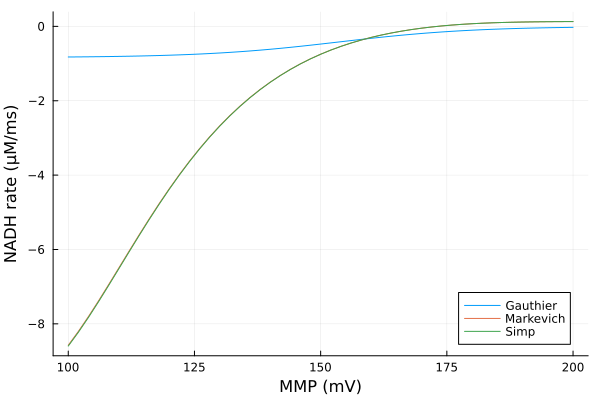

In [10]:
xs = dpsirange
ys = hcat(extract(sim_g, gauthier.vNADHC1), extract(sim_m, markevich.vNADHC1), extract(sim_s, sys.vNADHC1))

plot(xs, ys, xlabel="MMP (mV)", ylabel="NADH rate (μM/ms)", label=["Gauthier" "Markevich" "Simp"])

Flavin site

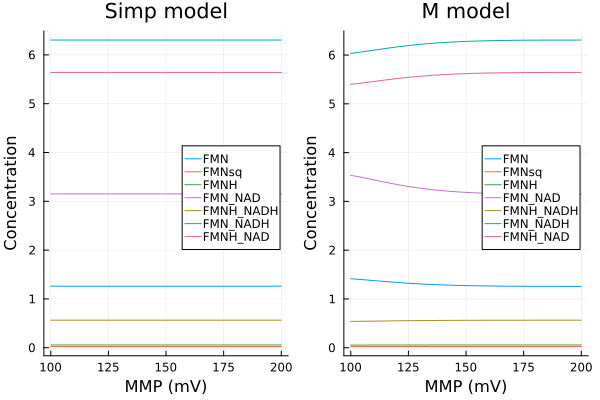

In [11]:
ys = stack(extract.(Ref(sim_s), [sys.FMN, sys.FMNsq, sys.FMNH, sys.FMN_NAD, sys.FMNH_NADH, sys.FMN_NADH, sys.FMNH_NAD]), dims=2)
pl1 = plot(xs, ys, xlabel="MMP (mV)", ylabel="Concentration", label=["FMN" "FMNsq" "FMNH" "FMN_NAD" "FMNH_NADH" "FMN_NADH" "FMNH_NAD"], title="Simp model", legend=:right)

ys = stack(extract.(Ref(sim_m), [markevich.FMN, markevich.FMNsq, markevich.FMNH, markevich.FMN_NAD, markevich.FMNH_NADH, markevich.FMN_NADH, markevich.FMNH_NAD]), dims=2)
pl2 = plot(xs, ys, xlabel="MMP (mV)", ylabel="Concentration", label=["FMN" "FMNsq" "FMNH" "FMN_NAD" "FMNH_NADH" "FMN_NADH" "FMNH_NAD"], title="M model", legend=:right)

plot(pl1, pl2)

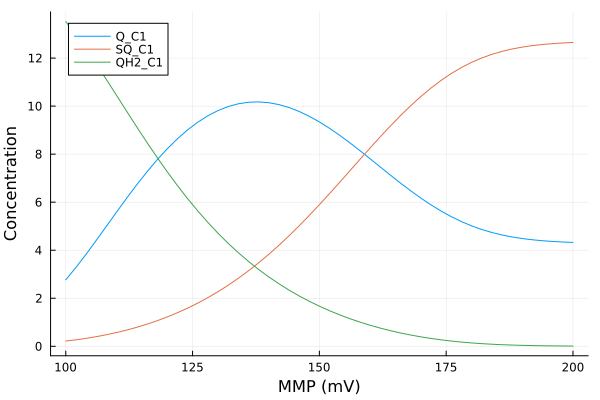

In [12]:
ys = stack(extract.(Ref(sim_s), [sys.Q_C1, sys.SQ_C1, sys.QH2_C1]), dims=2)
plot(xs, ys, xlabel="MMP (mV)", ylabel="Concentration", label=["Q_C1" "SQ_C1" "QH2_C1"])

MMP vs ROS production

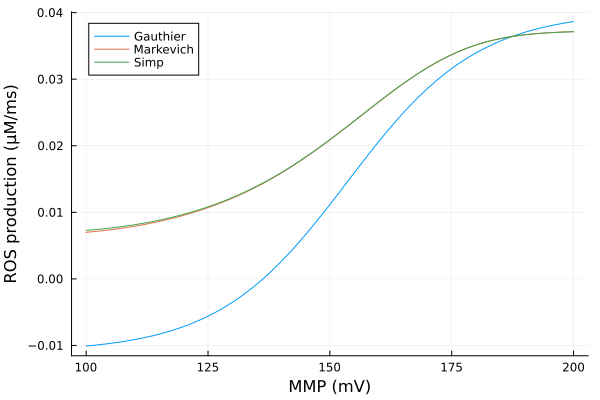

In [13]:
xs = dpsirange
ys_g = extract(sim_g, gauthier.vROSC1)
ys_m = extract(sim_m, markevich.vROSC1)
ys_s = extract(sim_s, sys.vROSC1)
plot(xs, [ys_g ys_m ys_s], xlabel="MMP (mV)", ylabel="ROS production (μM/ms)", label=["Gauthier" "Markevich" "Simp"])

## Varying NADH

In [14]:
nadhrange = 10μM:10μM:2990μM
alter_nadh = (prob, i, repeat) -> begin
    prob.ps[nadh] = nadhrange[i]
    prob.ps[nad] = 3000μM - prob.ps[nadh]
    prob
end

eprob_s = EnsembleProblem(prob_s; prob_func=alter_nadh)
eprob_g = EnsembleProblem(prob_g; prob_func=alter_nadh)
eprob_m = EnsembleProblem(prob_m; prob_func=alter_nadh)
@time sim_s = solve(eprob_s, alg, ealg; trajectories=length(nadhrange), abstol=1e-8, reltol=1e-8)
@time sim_g = solve(eprob_g, alg, ealg; trajectories=length(nadhrange), abstol=1e-8, reltol=1e-8)
@time sim_m = solve(eprob_m, alg, ealg; trajectories=length(nadhrange), abstol=1e-8, reltol=1e-8)

  0.866641 seconds (8.48 M allocations: 574.799 MiB, 26.65% gc time, 33.66% compilation time)
  1.546583 seconds (13.70 M allocations: 846.866 MiB, 46.67% gc time, 12.89% compilation time)
  1.994285 seconds (12.65 M allocations: 1.030 GiB, 33.98% gc time, 21.46% compilation time)


EnsembleSolution Solution of length 299 with uType:
SciMLBase.NonlinearSolution{_A, _B, _C, _D, SciMLBase.SteadyStateProblem{Vector{Float64}, true, ModelingToolkit.MTKParameters{Vector{Float64}, Vector{Float64}, Tuple{}, Tuple{}, Tuple{}, Tuple{}}, SciMLBase.ODEFunction{true, SciMLBase.FullSpecialize, ModelingToolkit.GeneratedFunctionWrapper{(2, 3, true), RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:__mtk_arg_1, :___mtkparameters___, :t), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0x0a273406, 0x0fdd74cd, 0xdf4adf45, 0x3ed90583, 0x502446a7), Nothing}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:ˍ₋out, :__mtk_arg_1, :___mtkparameters___, :t), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0x3390037b, 0xfd9b460f, 0x5e25f6b8, 0xf6ba2003, 0xc0d5e3e0), Nothing}}, LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, ModelingToolkit.ObservedFunc

NADH vs turnover

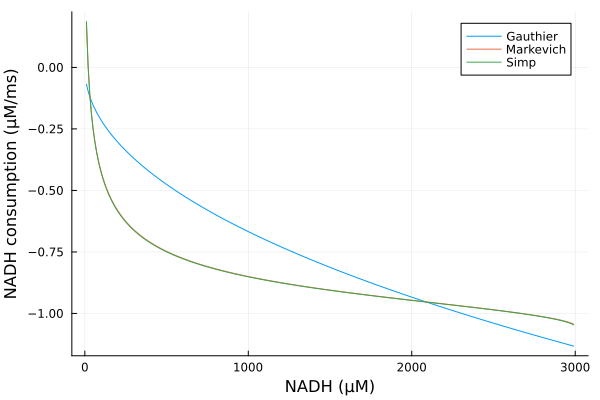

In [15]:
xs = nadhrange
ys_g = extract(sim_g, gauthier.vNADHC1)
ys_m = extract(sim_m, markevich.vNADHC1)
ys_s = extract(sim_s, sys.vNADHC1)

plot(xs, [ys_g ys_m ys_s], xlabel="NADH (μM)", ylabel="NADH consumption (μM/ms)", label=["Gauthier" "Markevich" "Simp"])

NADH vs ROS production

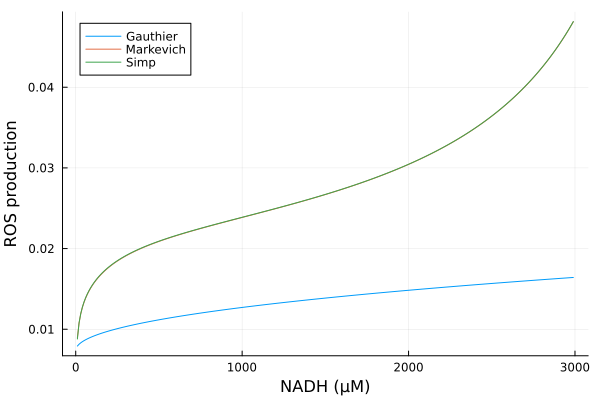

In [16]:
xs = nadhrange
ys = [extract(sim_g, gauthier.vROSC1) extract(sim_m, markevich.vROSC1) extract(sim_s, sys.vROSC1)]

plot(xs, ys, xlabel="NADH (μM)", ylabel="ROS production", label=["Gauthier" "Markevich" "Simp"])

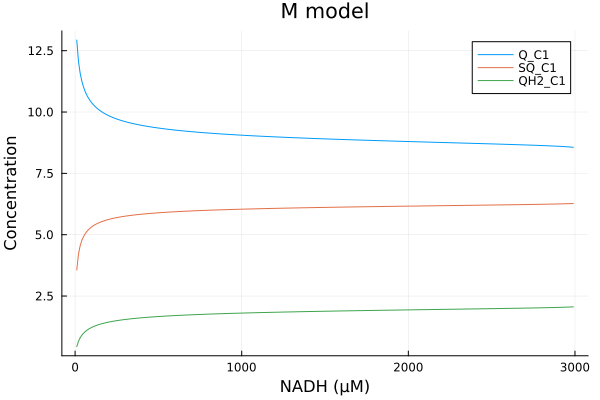

In [17]:
ys = stack(extract.(Ref(sim_m), [markevich.Q_C1, markevich.SQ_C1, markevich.QH2_C1]), dims=2)
plot(xs, ys, xlabel="NADH (μM)", ylabel="Concentration", label=["Q_C1" "SQ_C1" "QH2_C1"], title="M model")

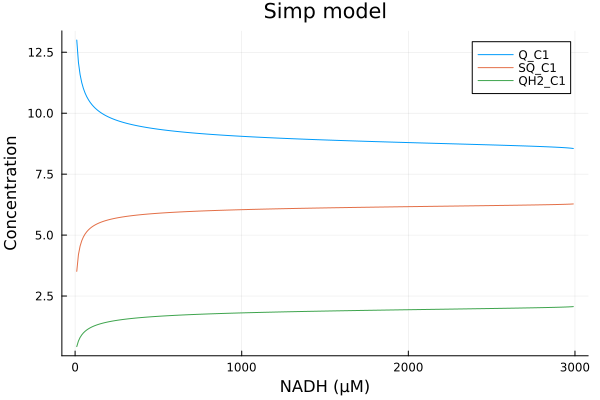

In [18]:
ys = stack(extract.(Ref(sim_s), [sys.Q_C1, sys.SQ_C1, sys.QH2_C1]), dims=2)
plot(xs, ys, xlabel="NADH (μM)", ylabel="Concentration", label=["Q_C1" "SQ_C1" "QH2_C1"], title="Simp model")

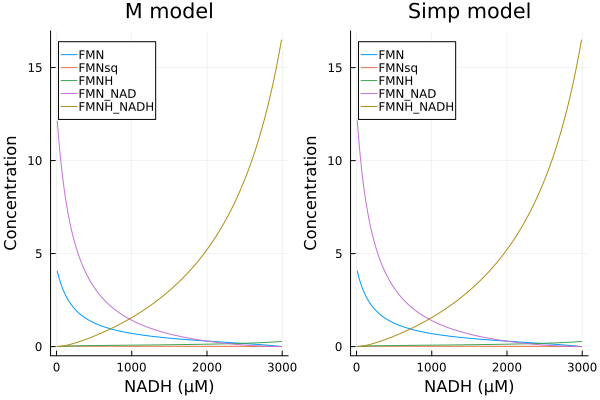

In [19]:
ys = stack(extract.(Ref(sim_m), [markevich.FMN, markevich.FMNsq, markevich.FMNH, markevich.FMN_NAD, markevich.FMNH_NADH]), dims=2)
pl1 = plot(xs, ys, xlabel="NADH (μM)", ylabel="Concentration", label=["FMN" "FMNsq" "FMNH" "FMN_NAD" "FMNH_NADH"], legend=:topleft, title="M model")

ys = stack(extract.(Ref(sim_s), [sys.FMN, sys.FMNsq, sys.FMNH, sys.FMN_NAD, sys.FMNH_NADH]), dims=2)
pl2 = plot(xs, ys, xlabel="NADH (μM)", ylabel="Concentration", label=["FMN" "FMNsq" "FMNH" "FMN_NAD" "FMNH_NADH"] , title="Simp model")

plot(pl1, pl2)

## Varying Q

In [20]:
qh2range = 10μM:10μM:1990μM
alter_qh2 = (prob, i, repeat) -> begin
    prob.ps[QH2_n] = qh2range[i]
    prob.ps[Q_n] = 2000μM - prob.ps[QH2_n]
    prob
end

eprob_s = EnsembleProblem(prob_s; prob_func=alter_qh2)
eprob_g = EnsembleProblem(prob_g; prob_func=alter_qh2)
eprob_m = EnsembleProblem(prob_m; prob_func=alter_qh2)
@time sim_s = solve(eprob_s, alg, ealg; trajectories=length(qh2range), abstol=1e-8, reltol=1e-8)
@time sim_g = solve(eprob_g, alg, ealg; trajectories=length(qh2range), abstol=1e-8, reltol=1e-8)
@time sim_m = solve(eprob_m, alg, ealg; trajectories=length(qh2range), abstol=1e-8, reltol=1e-8)

  0.458336 seconds (5.68 M allocations: 384.440 MiB, 12.24% gc time, 35.89% compilation time)
  0.833349 seconds (9.19 M allocations: 567.046 MiB, 39.26% gc time, 17.29% compilation time)
  1.043247 seconds (8.72 M allocations: 747.685 MiB, 27.21% gc time, 15.38% compilation time)


EnsembleSolution Solution of length 199 with uType:
SciMLBase.NonlinearSolution{_A, _B, _C, _D, SciMLBase.SteadyStateProblem{Vector{Float64}, true, ModelingToolkit.MTKParameters{Vector{Float64}, Vector{Float64}, Tuple{}, Tuple{}, Tuple{}, Tuple{}}, SciMLBase.ODEFunction{true, SciMLBase.FullSpecialize, ModelingToolkit.GeneratedFunctionWrapper{(2, 3, true), RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:__mtk_arg_1, :___mtkparameters___, :t), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0x0a273406, 0x0fdd74cd, 0xdf4adf45, 0x3ed90583, 0x502446a7), Nothing}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:ˍ₋out, :__mtk_arg_1, :___mtkparameters___, :t), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0x3390037b, 0xfd9b460f, 0x5e25f6b8, 0xf6ba2003, 0xc0d5e3e0), Nothing}}, LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, ModelingToolkit.ObservedFunc

QH2 vs NADH turnover

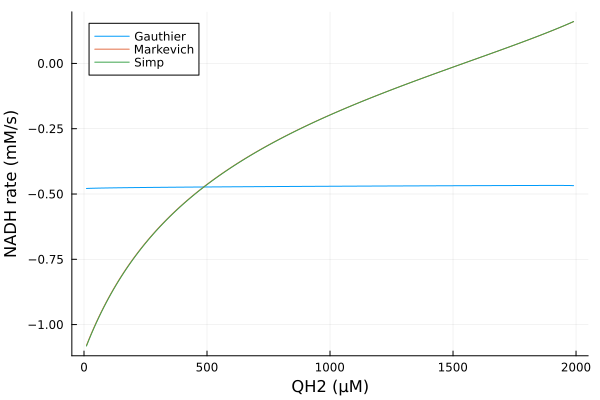

In [21]:
xs = qh2range
ys = [extract(sim_g, gauthier.vNADHC1) extract(sim_m, markevich.vNADHC1) extract(sim_s, sys.vNADHC1)]

plot(xs, ys, xlabel="QH2 (μM)", ylabel="NADH rate (mM/s)", label=["Gauthier" "Markevich" "Simp"])

QH2 vs ROS production
Gauthier model is sensitive to high QH2 because of slow NAD binding

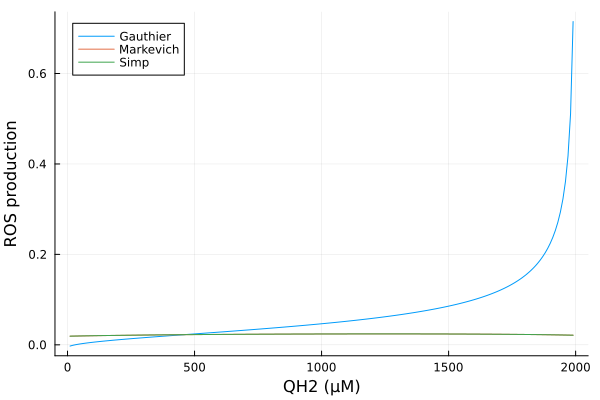

In [22]:
xs = qh2range
ys = [extract(sim_g, gauthier.vROSC1) extract(sim_m, markevich.vROSC1) extract(sim_s, sys.vROSC1)]
plot(xs, ys, xlabel="QH2 (μM)", ylabel="ROS production", label=["Gauthier" "Markevich" "Simp"])

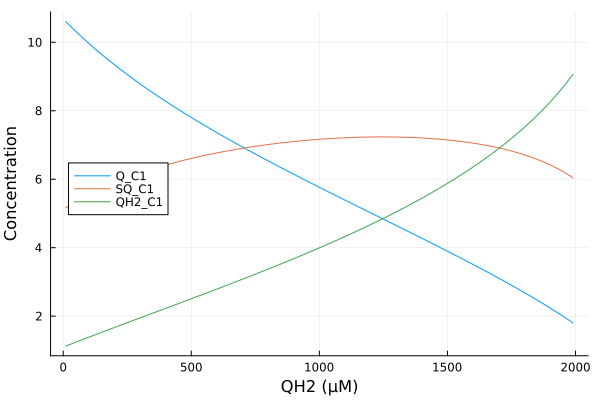

In [23]:
ys = stack(extract.(Ref(sim_s), [sys.Q_C1, sys.SQ_C1, sys.QH2_C1]), dims=2)
plot(xs, ys, xlabel="QH2 (μM)", ylabel="Concentration", label=["Q_C1" "SQ_C1" "QH2_C1"], legend=:left)

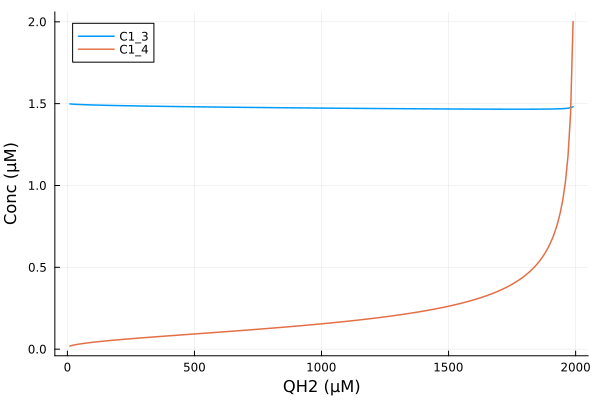

In [24]:
@unpack C1_1, C1_3, C1_4, C1_5, C1_6, C1_7 = gauthier
ys = stack(extract.(Ref(sim_g), [C1_3, C1_4]), dims=2)
plot(xs, ys, xlabel="QH2 (μM)", ylabel="Conc (μM)", label=["C1_3" "C1_4"], lw=1.5)

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*